# Q2 - Mushroom Classification
## Alireza Habibzadeh `99109393`

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

## وارد کردن داده‌ها و تقسیم به داده‌های آموزشی، اعتبارسنجی و آزمون

In [28]:
def split_data(data):
    X = data.iloc[:, 1:]  # Features
    y = data.iloc[:, 0]   # Target
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3)
    return X_train, X_val, X_test, y_train, y_val, y_test

data = pd.read_csv('mushrooms.csv', na_values='?')
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)

## 1. برخورد با مقادیر خالی
برای برخورد با آن‌هایی که میس شده‌اند آن‌ها را با پرتکرارترینشان در داده‌های آموزشی جایگزین می‌کنیم.
چون این داده‌ها به صورت کتگوریکال هستند و می‌توانند مقادیر متفاوتی داشته باشند، از میانگین استفاده نمی‌کنیم.

ضمنا حواسمان هست پرتکرارترین را تنها روی داده‌های آموزشی پیدا کنیم و نتیجه را روی همه‌ی دیتاست‌ها اعمال کنیم تا از داده‌های غیرآموزشی نشت نداشته باشیم.

In [29]:
def handle_missing_values(X_train, X_val, X_test):
    print(f'Number of missing values in training data before imputation: {X_train.isnull().sum().sum()}')
    
    imputer = SimpleImputer(strategy='most_frequent')
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    return X_train_imputed, X_val_imputed, X_test_imputed

X_train_imputed, X_val_imputed, X_test_imputed = handle_missing_values(X_train, X_val, X_test)

Number of missing values in training data before imputation: 1745


## انکود داده‌ها
باید داده‌های کتگوریکال را به اعداد مپ کنیم تا مدل بتواند با آن کار کند.

In [30]:
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train_imputed)
X_val_encoded = encoder.transform(X_val_imputed)
X_test_encoded = encoder.transform(X_test_imputed)

## 2.

In [31]:
def find_decision_tree(X_train, X_val, y_train, y_val):
    depths = [4, 8, 16, 24, 32]
    best_model, best_accuracy, best_depth = None, 0, None
    
    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth, criterion='gini')
        model.fit(X_train, y_train)
        accuracy = accuracy_score(y_val, model.predict(X_val))
        if accuracy > best_accuracy:
            best_model, best_accuracy, best_depth = model, accuracy, depth

    return best_model, best_depth

best_model, best_depth = find_decision_tree(X_train_encoded, X_val_encoded, y_train, y_val)

train_error = 1 - accuracy_score(y_train, best_model.predict(X_train_encoded))
test_error = 1 - accuracy_score(y_test, best_model.predict(X_test_encoded))

print(f'Best Depth: {best_depth}')
print(f'Training Error: {train_error:.2%}')
print(f'Test Error: {test_error:.2%}')

Best Depth: 8
Training Error: 0.00%
Test Error: 0.00%


## 3.

In [32]:
from sklearn.ensemble import RandomForestClassifier

def train_random_forest_models(X_train, y_train, X_val, y_val):
    max_depths = [4, 8, 12, 16]
    max_features = [3, 5, 7]
    best_model = None
    best_accuracy = 0
    best_params = None
    results = []

    for depth in max_depths:
        for features in max_features:
            model = RandomForestClassifier(n_estimators=7, max_depth=depth, max_features=features)
            model.fit(X_train, y_train)
            training_accuracy = accuracy_score(y_train, model.predict(X_train))
            validation_accuracy = accuracy_score(y_val, model.predict(X_val))
            results.append((depth, features, training_accuracy, validation_accuracy))

            if validation_accuracy > best_accuracy:
                best_accuracy = validation_accuracy
                best_model = model
                best_params = (depth, features)

    return best_model, best_params, results


best_rf_model, best_rf_params, rf_results = train_random_forest_models(X_train_encoded, y_train, X_val_encoded, y_val)

for depth, features, training_accuracy, validation_accuracy in rf_results:
    print(f'Depth: {depth}, Features: {features}, Training Accuracy: {training_accuracy:.2%}, Validation Accuracy: {validation_accuracy:.2%}')

test_accuracy_rf = accuracy_score(y_test, best_rf_model.predict(X_test_encoded))
print(f'Test Accuracy: {test_accuracy_rf:.2%}')
print(f'Best Parameters: Depth = {best_rf_params[0]}, Features = {best_rf_params[1]}')

Depth: 4, Features: 3, Training Accuracy: 92.65%, Validation Accuracy: 93.29%
Depth: 4, Features: 5, Training Accuracy: 92.51%, Validation Accuracy: 92.86%
Depth: 4, Features: 7, Training Accuracy: 96.32%, Validation Accuracy: 96.68%
Depth: 8, Features: 3, Training Accuracy: 99.00%, Validation Accuracy: 99.02%
Depth: 8, Features: 5, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 8, Features: 7, Training Accuracy: 99.88%, Validation Accuracy: 99.82%
Depth: 12, Features: 3, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 12, Features: 5, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 12, Features: 7, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 16, Features: 3, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 16, Features: 5, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Depth: 16, Features: 7, Training Accuracy: 100.00%, Validation Accuracy: 100.00%
Test Accuracy: 100.00%
Best Parameters: Dept

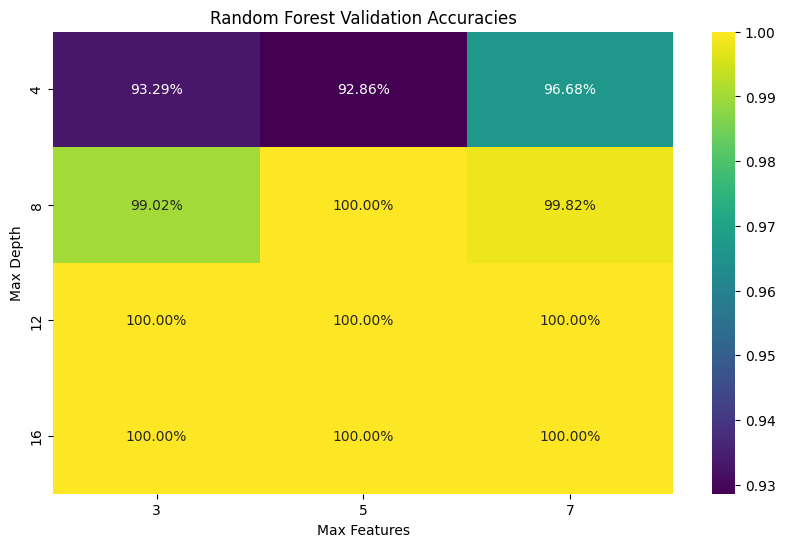

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

vis_data = pd.DataFrame(rf_results, columns=['Max Depth', 'Max Features', 'Training Accuracy', 'Validation Accuracy'])

pivot_table = vis_data.pivot(index='Max Depth', columns='Max Features', values='Validation Accuracy')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.2%', cmap='viridis')
plt.title('Random Forest Validation Accuracies')
plt.ylabel('Max Depth')
plt.xlabel('Max Features')
plt.show()